In [154]:
from __future__ import division
import os, sys, glob, subprocess
import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib
%matplotlib nbagg
import matplotlib.pyplot as plt


# PCA on 30min smartthings background
- 1 sec period
- pkt_counter = (srcip, sport, dstip, dport, proto, direction, pkt_len): COUNT
- byte_counter = (srcip, sport, dstip, dport, proto, direction): SUM_BYTE

## GENERATE flow x time dataframes for device bg and activity

In [164]:
DATA = {}

# SMARTTHINGS bg time stamp 1 (night) and 2 (late night)
DATA['smart1'] = "processed/smartthings_bg_8hr_kevins/t1000_d1800_p1/"
cmd = "python src/main.py -r data/smartthings_bg_8hr_kevins.pcap -m d0:52:a8:00:81:b6 -o "+DATA['smart1']+" -t 1000.0 -d 1800.0 -s all -p 1.0"
print subprocess.check_output(cmd, shell=True)

DATA['smart2'] = "processed/smartthings_bg_8hr_kevins/t15000_d1800_p1/"
cmd = "python src/main.py -r data/smartthings_bg_8hr_kevins.pcap -m d0:52:a8:00:81:b6 -o "+DATA['smart2']+" -t 15000.0 -d 1800.0 -s all -p 1.0"
print subprocess.check_output(cmd, shell=True)

# NEST time stamp 1 (evening) and 2 (late night)
DATA['nest1'] = "processed/nest_bg_2days/t1000_d7200_p1/"
cmd = "python src/main.py -r data/nest_bg_2days.pcap -m 18:b4:30:14:52:1d -o "+DATA['nest1'] +" -t 1000.0 -d 7200.0 -s all -p 1.0"
print subprocess.check_output(cmd, shell=True)

DATA['nest2'] = "processed/nest_bg_2days/t30000_d7200_p1/"
cmd = "python src/main.py -r data/nest_bg_2days.pcap -m 18:b4:30:14:52:1d -o "+DATA['nest2'] +" -t 30000.0 -d 7200.0 -s all -p 1.0"
print subprocess.check_output(cmd, shell=True)

# smartthings activity
DATA['smart3'] = "processed/smartthings_door_9times_kevins/t0_d1800_p1/"
cmd = "python src/main.py -r data/smartthings_door_9times_kevins.pcap -m d0:52:a8:00:81:b6 -o "+DATA['smart3']+" -t 0.0 -d 1800.0 -s all -p 1.0"
print subprocess.check_output(cmd, shell=True)

# ipcam bg alarm mode
DATA['ipcam1'] = "processed/ipcam_bg_10hr_kevins/t1000_d1800_p1/"
cmd = "python src/main.py -r data/echo_ipcam_bg_10hr_kevins.pcap -m 00:e0:4c:b7:3c:d2 -o "+DATA['ipcam1']+" -t 1000.0 -d 1800.0 -s all -p 1.0"
print subprocess.check_output(cmd, shell=True)

# echo bg
DATA['echo1'] = "processed/echo_bg_10hr_kevins/t0_d1800_p1/"
cmd = "python src/main.py -r data/echo_ipcam_bg_10hr_kevins.pcap -m 74:75:48:9b:70:25 -o "+DATA['echo1']+" -t 0.0 -d 1800.0 -s flow -p 1.0"
# use -s flow as counter.log gives json dump error
print subprocess.check_output(cmd, shell=True)

# echo activity
DATA['echo2'] = "processed/echo_ipcam_activity_15mins_kevins/t0_d1800_p1/"
cmd = "python src/main.py -r data/echo_ipcam_activity_15mins_kevins.pcap -m 74:75:48:9b:70:25 -o "+DATA['echo2']+" -t 0.0 -d 1800.0 -s all -p 1.0"
print subprocess.check_output(cmd, shell=True)

Run CounterLog(). Save to processed/smartthings_bg_8hr_kevins/t1000_d1800_p1/counter.log
Run DNSLog(). Save to processed/smartthings_bg_8hr_kevins/t1000_d1800_p1/dns.log
Run FlowLog(time_period). Save to processed/smartthings_bg_8hr_kevins/t1000_d1800_p1/flow.log

Run CounterLog(). Save to processed/smartthings_bg_8hr_kevins/t15000_d1800_p1/counter.log
Run DNSLog(). Save to processed/smartthings_bg_8hr_kevins/t15000_d1800_p1/dns.log
Run FlowLog(time_period). Save to processed/smartthings_bg_8hr_kevins/t15000_d1800_p1/flow.log

Run CounterLog(). Save to processed/nest_bg_2days/t1000_d1800_p1/counter.log
Run DNSLog(). Save to processed/nest_bg_2days/t1000_d1800_p1/dns.log
Run FlowLog(time_period). Save to processed/nest_bg_2days/t1000_d1800_p1/flow.log

Run CounterLog(). Save to processed/nest_bg_2days/t30000_d1800_p1/counter.log
Run DNSLog(). Save to processed/nest_bg_2days/t30000_d1800_p1/dns.log
Run FlowLog(time_period). Save to processed/nest_bg_2days/t30000_d1800_p1/flow.log

Run Co

CalledProcessError: Command 'python src/main.py -r data/echo_ipcam_bg_10hr_kevins.pcap -m 74:75:48:9b:70:25 -o processed/echo_bg_10hr_kevins/t0_d1800_p1/ -t 0.0 -d 1800.0 -s all -p 1.0' returned non-zero exit status 1

In [189]:
#PLOTS = {}
#for key, data in DATA.iteritems():
#    PLOTS[key] = data.replace('processed', 'output')
#    if not os.path.exists(PLOTS[key]):
#        os.makedirs(PLOTS[key])

PLOTS = 'output/PCA_comparison/'
if not os.path.exists(PLOTS):
    os.makedirs(PLOTS)

for folder in DATA.keys():
    if not os.path.exists('output/'+ folder):
        os.makedirs('output/'+ folder)

def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

## LOAD AND OBSERVE DATA

In [190]:
data_pkt = {}
data_byte = {}

for folder in ['smart1', 'smart2', 'smart3', 'nest1', 'nest2', 'ipcam1', 'echo1', 'echo2']:
    data_pkt[folder] = pd.read_pickle(DATA[folder] + 'df_pkt_counter.pkl')
    data_byte[folder] = pd.read_pickle(DATA[folder] + 'df_byte_counter.pkl')

<IPython.core.display.Javascript object>


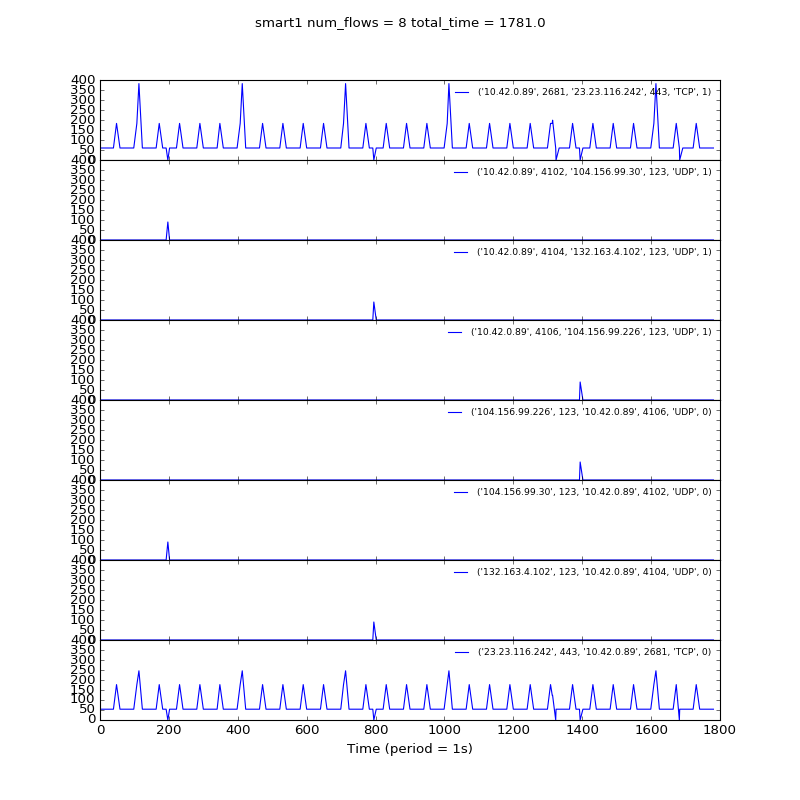

<IPython.core.display.Javascript object>


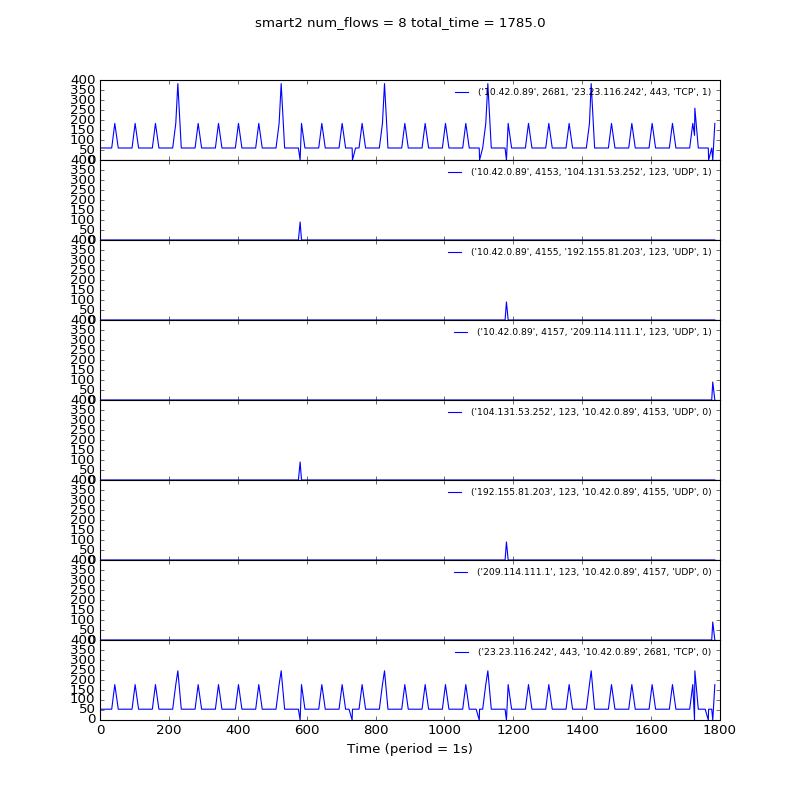

<IPython.core.display.Javascript object>


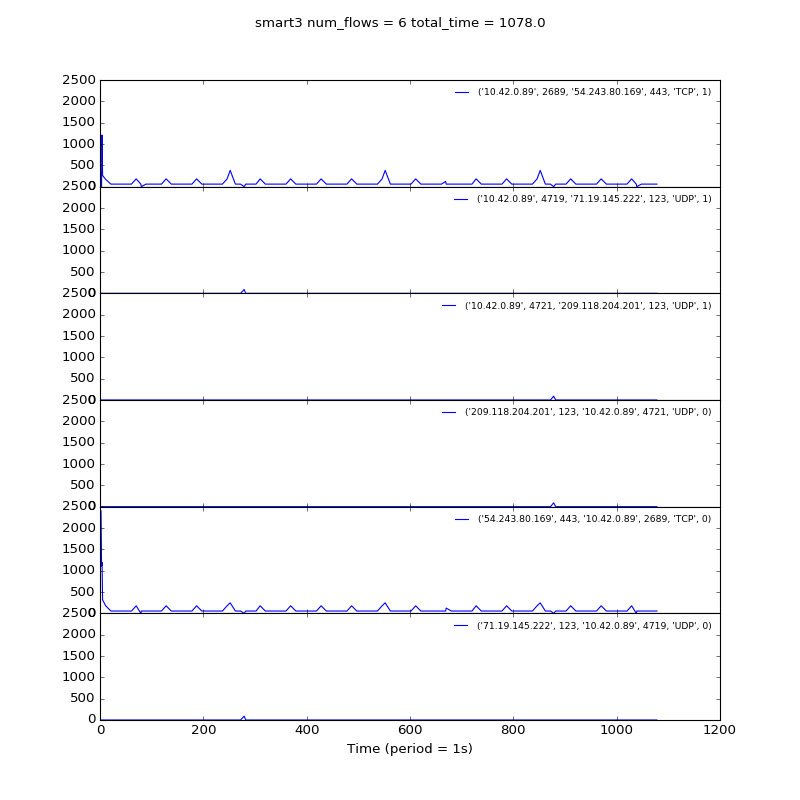

<IPython.core.display.Javascript object>


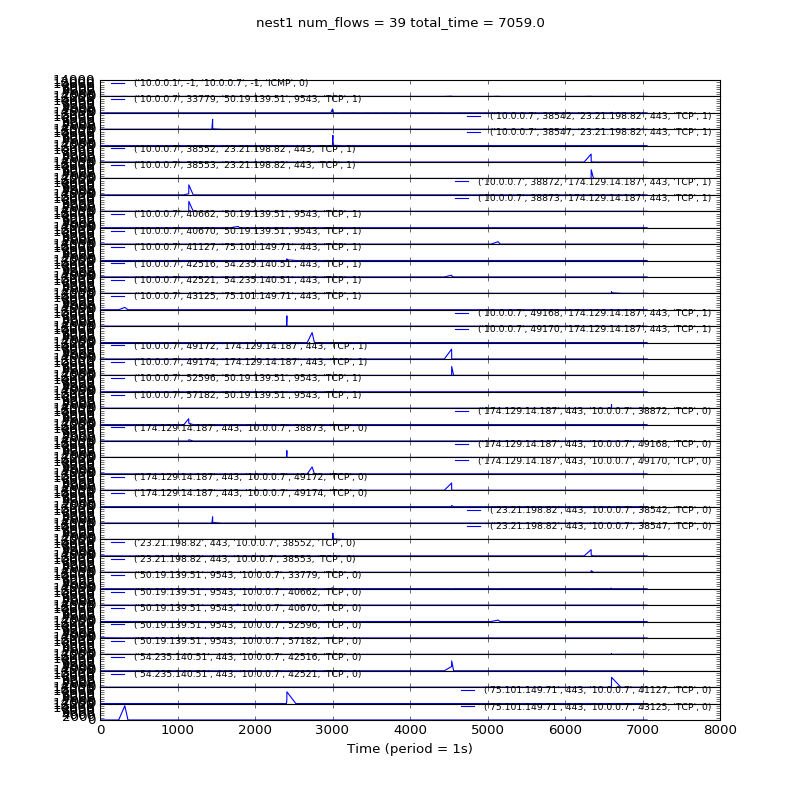

<IPython.core.display.Javascript object>


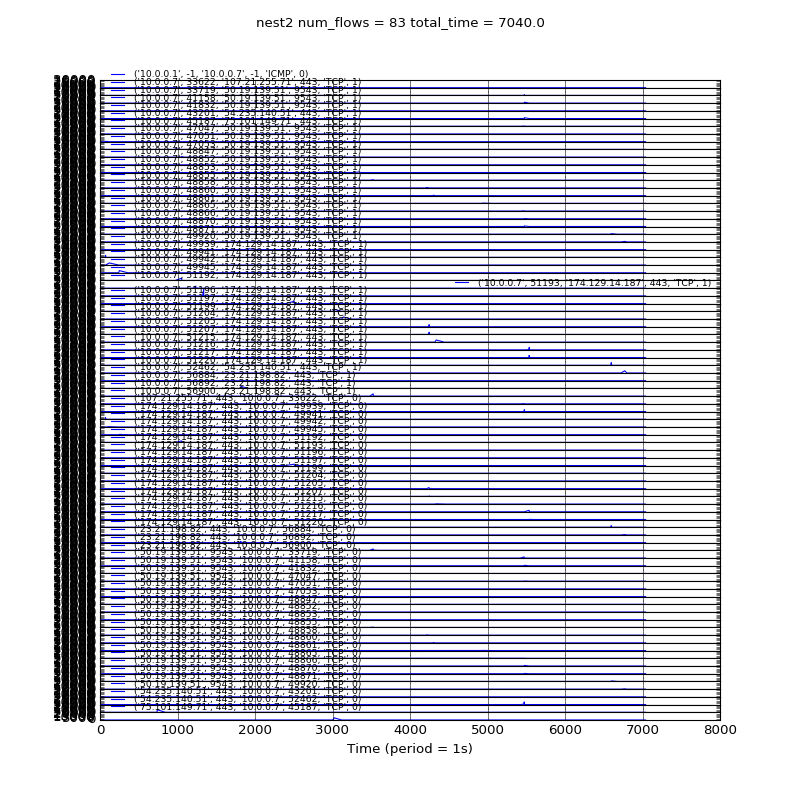

In [191]:
for folder in ['smart1', 'smart2', 'smart3', 'nest1', 'nest2']:
    df = data_byte[folder]
    cols = df.columns
    fig1, axes = plt.subplots(len(cols), 1, sharex=True, sharey=True, figsize=(10,10))
    ind = 0
    for col in cols:
        ax1 = axes[ind]
        ax1.plot(df[col], label=col)
        ind+=1
        ax1.legend(loc='best', frameon=False, fontsize='x-small')
    fig1.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in axes[:-1]], visible=False)
    #fig1.tight_layout()
    ax1.set_xlabel('Time (period = 1s)')
    fig1.suptitle(folder + " num_flows = " + str(len(cols)) + " total_time = "+str(df.index[-1]))
    fig1.savefig('output/' + folder + '/flow_bytes')

<IPython.core.display.Javascript object>


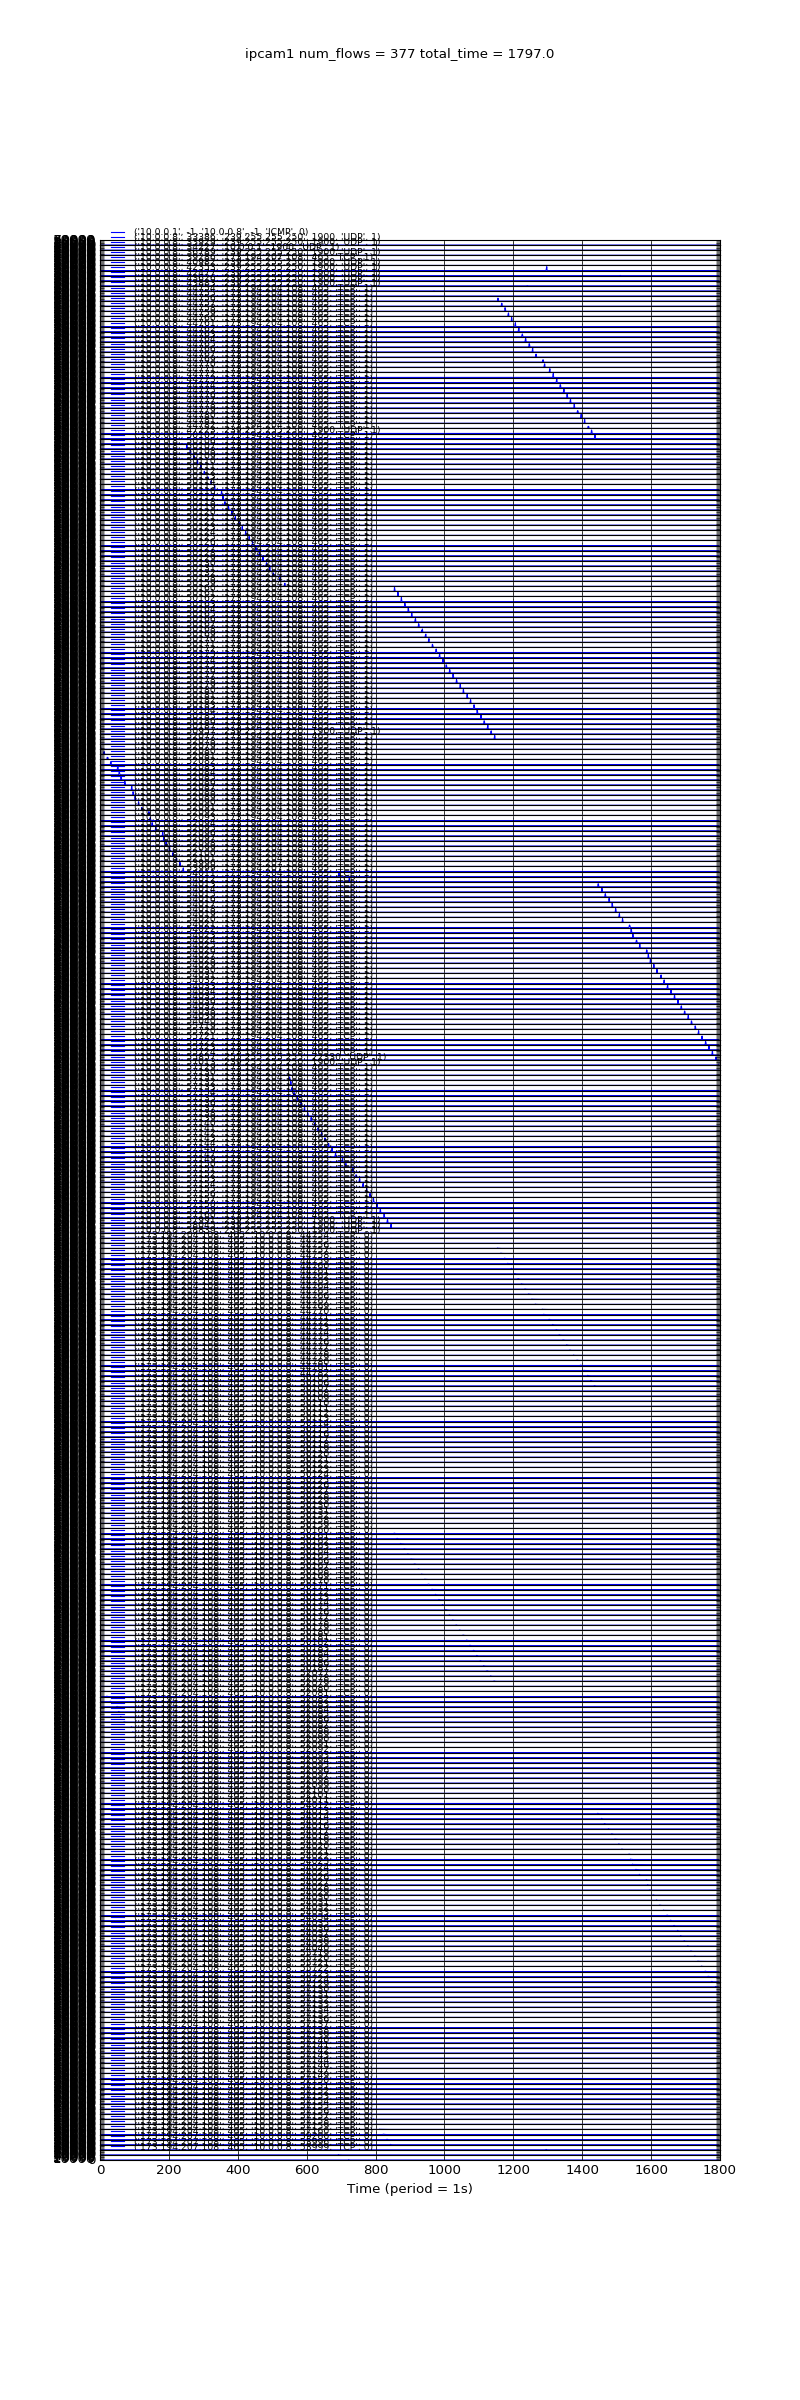

<IPython.core.display.Javascript object>


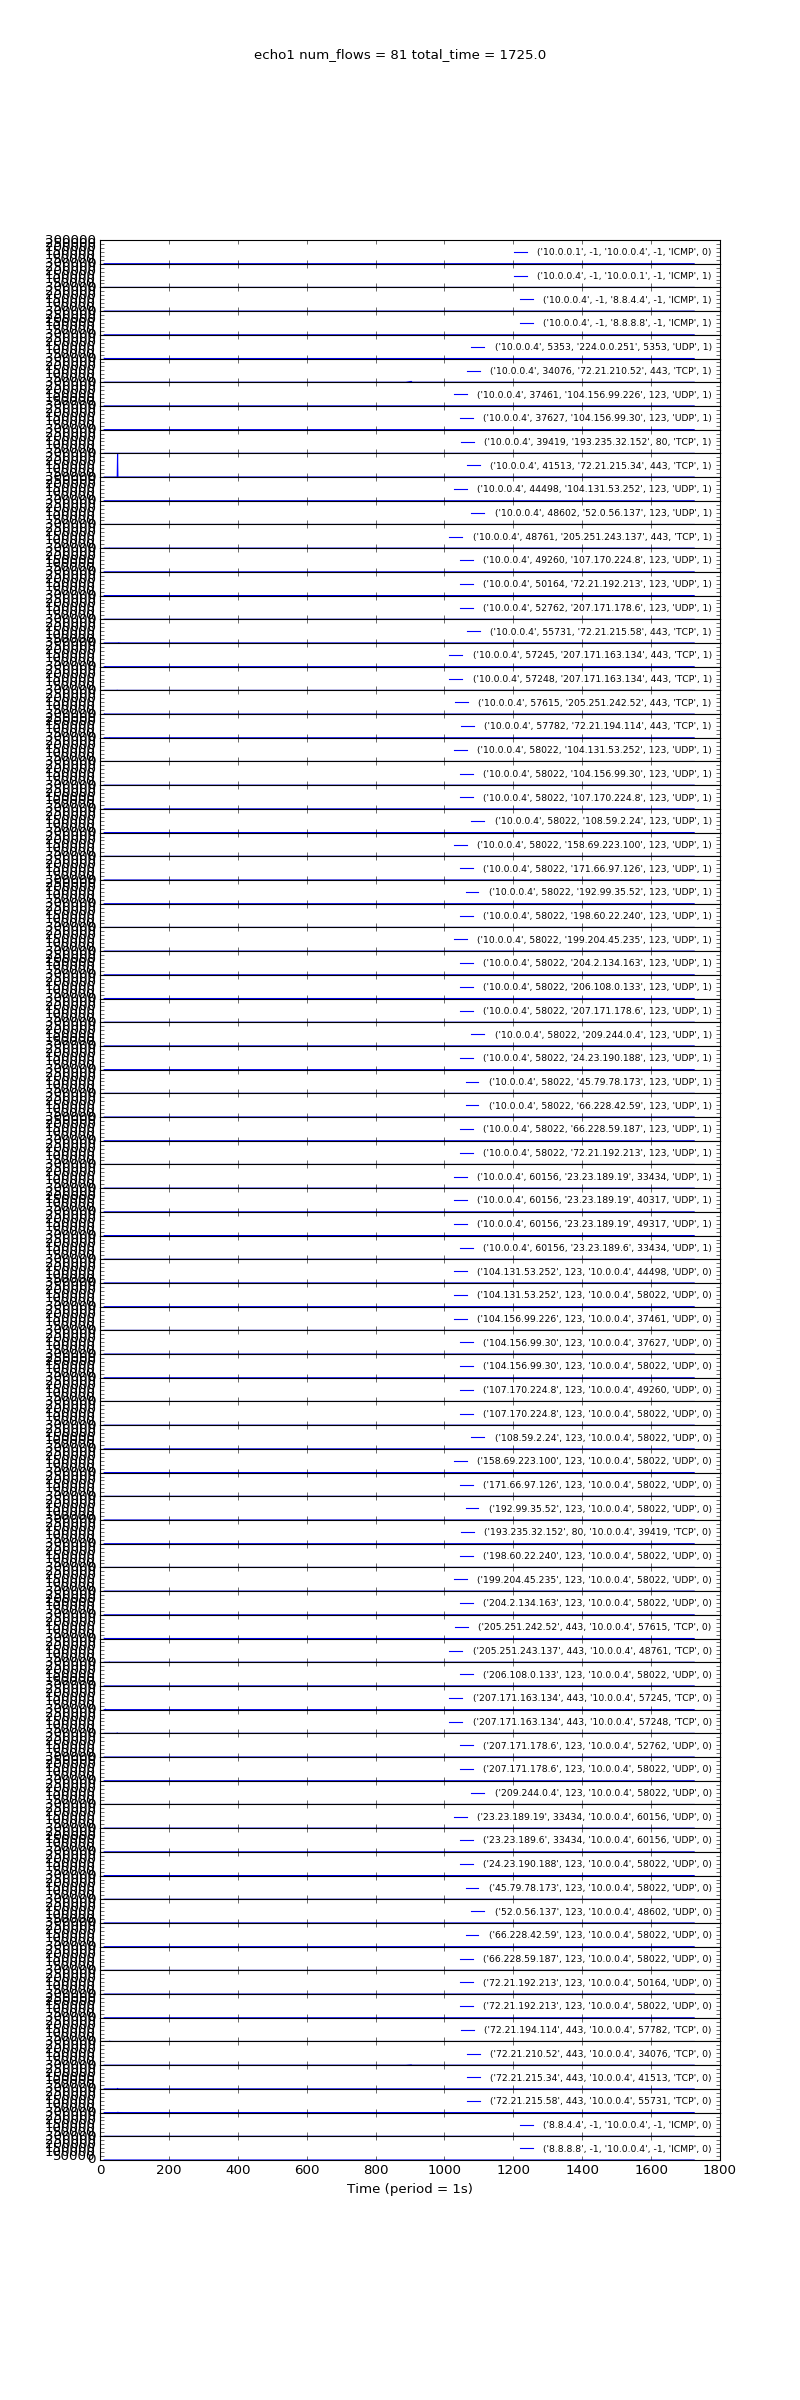

<IPython.core.display.Javascript object>


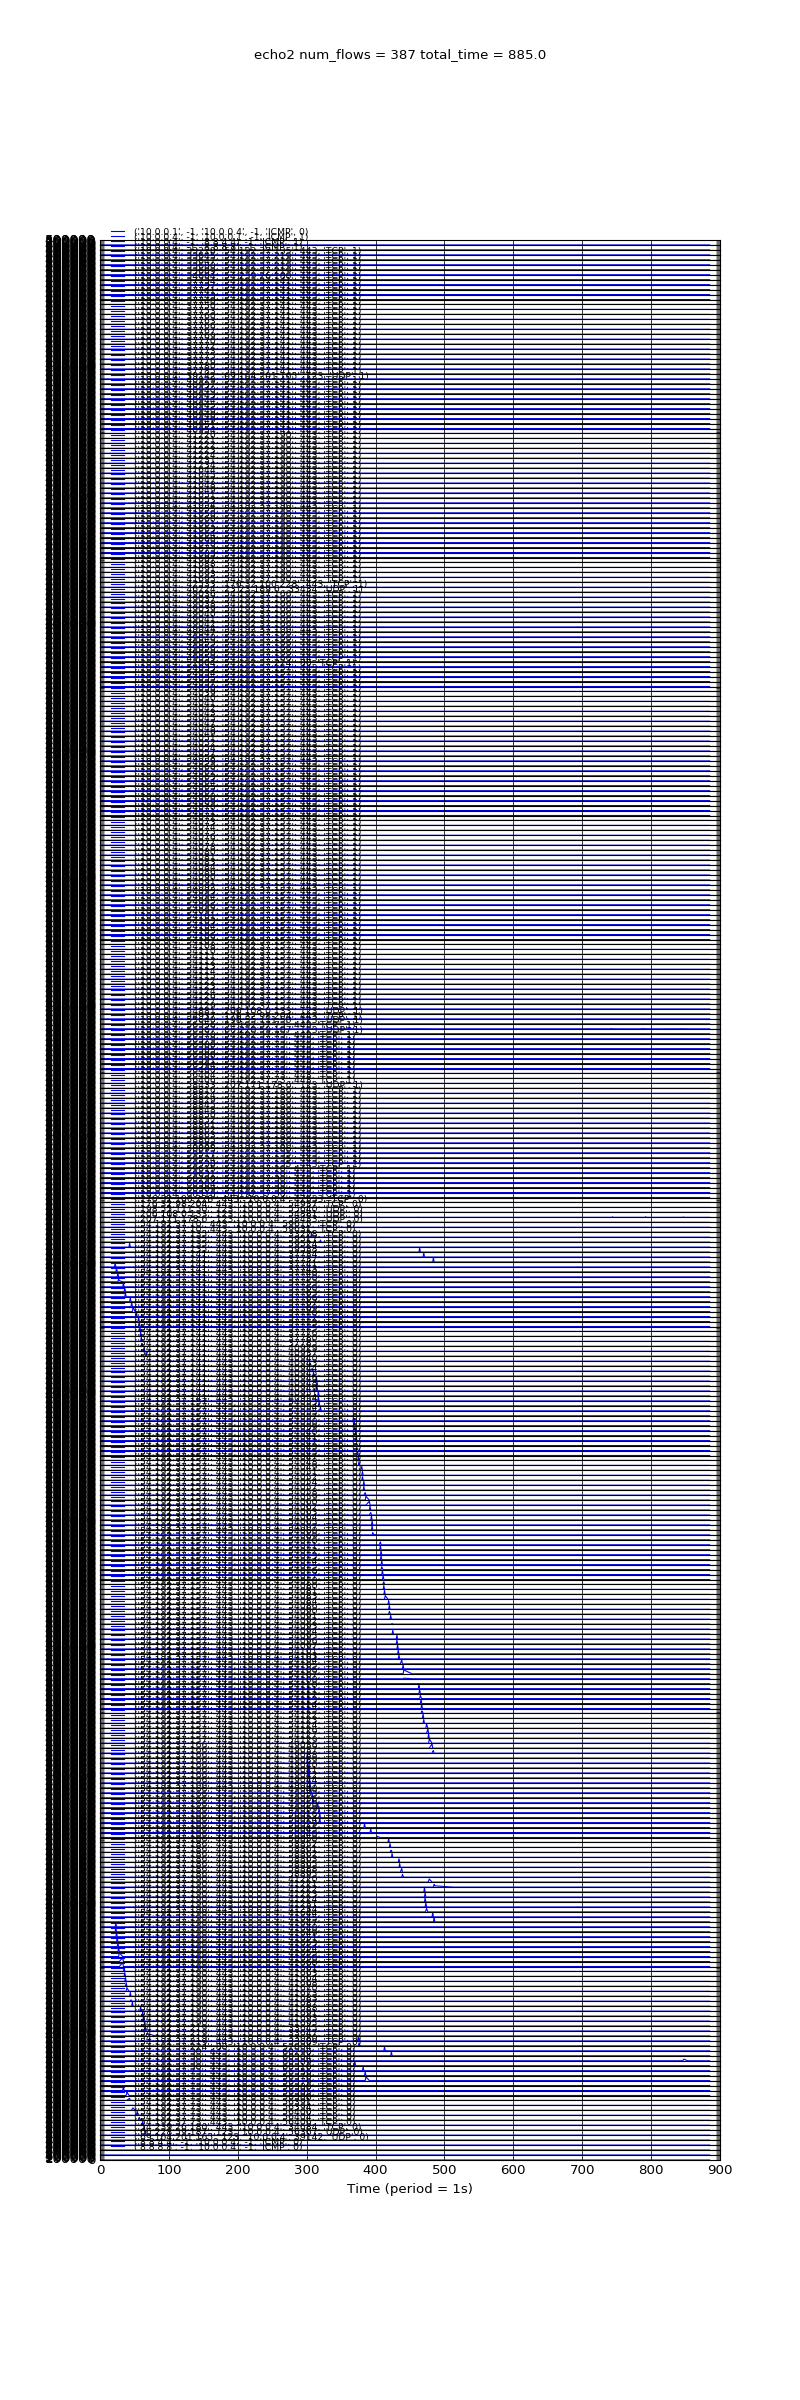

In [192]:
for folder in ['ipcam1', 'echo1', 'echo2']:
    df = data_byte[folder]
    cols = df.columns
    fig1, axes = plt.subplots(len(cols), 1, sharex=True, sharey=True, figsize=(10,30))
    ind = 0
    for col in cols:
        ax1 = axes[ind]
        ax1.plot(df[col], label=col)
        ind+=1
        ax1.legend(loc='best', frameon=False, fontsize='x-small')
    fig1.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in axes[:-1]], visible=False)
    #fig1.tight_layout()
    ax1.set_xlabel('Time (period = 1s)')
    fig1.suptitle(folder + " num_flows = " + str(len(cols)) + " total_time = "+str(df.index[-1]))
    fig1.savefig('output/' + folder + '/flow_bytes')

## PCA functions

In [91]:
from numpy.linalg import eigh

def estimateCovariance(df):
    df_zero = df - df.mean()
    df_cov = df_zero.cov()
    #DataZeroMean.map(lambda s: np.outer(s,s)).mean()
    return df_cov

def pca(data, k=2):
    eigVals, eigVecs = eigh(estimateCovariance(data))
    inds = np.argsort(eigVals)[::-1]
    topComponents = eigVecs[:,inds[:k]]
    score = data.dot(topComponents)
    # Return the `k` principal components, `k` scores, and all eigenvalues
    return (topComponents, score, eigVals[inds])

In [92]:
K = 7
topComponents, scores, eigenvalues = pca(df_pkt, K)
for k in range(1,K+1):
    print "% variance covered by top ", k, " components: ", 100*sum(eigenvalues[:k])/sum(eigenvalues)  

% variance covered by top  1  components:  71.998464539
% variance covered by top  2  components:  84.7539767581
% variance covered by top  3  components:  94.3747015482
% variance covered by top  4  components:  96.2450501577
% variance covered by top  5  components:  98.1153987672
% variance covered by top  6  components:  99.4272756777
% variance covered by top  7  components:  100.0


<IPython.core.display.Javascript object>


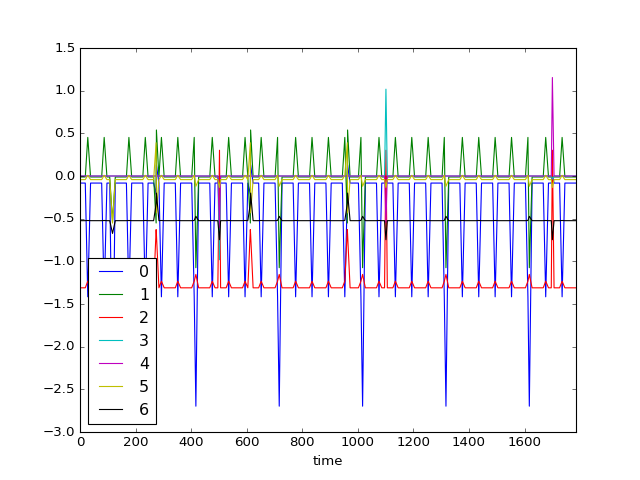

In [93]:
scores.plot()

<IPython.core.display.Javascript object>


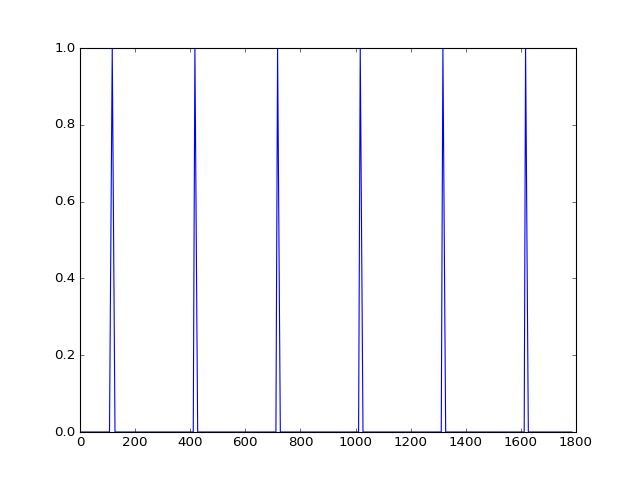

In [141]:
fig1, ax1 = plt.subplots(1,1)
ax1.plot(df_pkt[cols[2]])

In [152]:
len( sig )

191

<IPython.core.display.Javascript object>


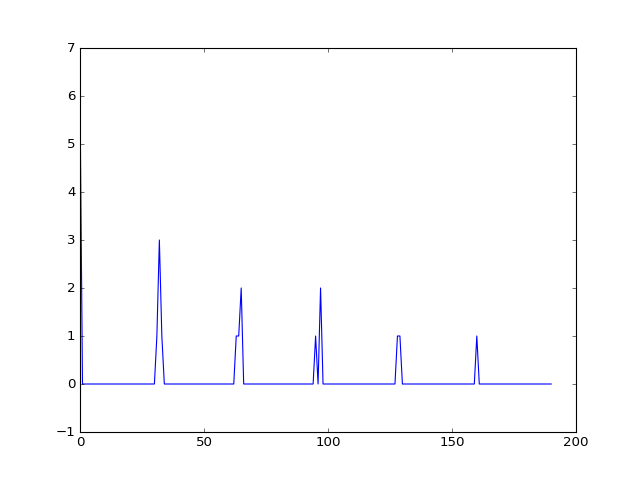

In [153]:
from scipy import signal
#xx = [0,-10,0,10,0,-10,0,10,0,-10,0,10,0,-10,0,10,0,-10,0,10,0,-10,0,10]'
cols = df_pkt.columns

sig = df_pkt[cols[2]]
#f, px = signal.periodogram(df_pkt[cols[2]])
# WRONG - take into account time index and add 0s in between to get true frequency / sample original ~ 10s
corr = signal.fftconvolve(sig, sig[::-1], mode='full')
corr = corr[int(len(corr)/2) :]

fig1, ax1 = plt.subplots(1,1)
ax1.plot(corr)
#ax1.specgram(scores[0])
#ax1.plot( np.fft.rfft(scores[1]) )
#ax1.psd( scores[0] , Fs=2.)

In [65]:
K = 5
topComponents, scores, eigenvalues = pca(df_byte, K)
for k in range(1,K+1):
    print "% variance covered by top ", k, " components: ", 100*sum(eigenvalues[:k])/sum(eigenvalues)  

% variance covered by top  1  components:  94.9076197248
% variance covered by top  2  components:  96.9953622708
% variance covered by top  3  components:  98.0142536269
% variance covered by top  4  components:  99.033144983
% variance covered by top  5  components:  100.0


<IPython.core.display.Javascript object>


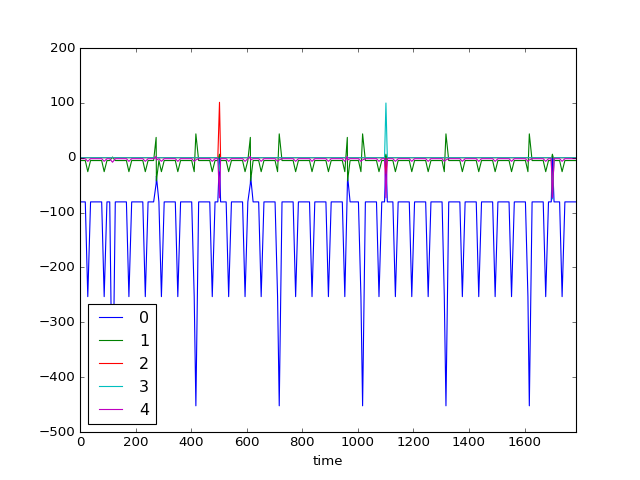

In [66]:
scores.plot()

In [ ]:
colors = ['k','k','k','r']
x = range(1, 1+len(time_slots))
# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
ax1.set_title('Eigen Flows')
axes = [ax1, ax2, ax3, ax4]
ind = 0
projections = np.array(scores.collect())
print projections.shape
for pc in [5,6,7,8]:
    axes[ind].plot(x, [z/1000000 for z in projections[:,pc]])
    ind += 1
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.xlabel('Time Slot (5 minutes)')

plt.show()
pass